In [27]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Proof of concept: try fine-tuning MNIST classifier by freezing feature extractor and creating new classes I M P C, 1 2 3 4 and upper lower

1. get data: 5 samples of all teeth. 11 classes -> 60 images.
2. finetune
3. evaluate

## Load the keras model. Try reading one sample

### Test inference with MNIST

In [176]:
mnist_model = tf.keras.models.load_model('/home/riikoro/thesis/code/pretrained_base_models/bangla_english_handwritten_mnist.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Restored model, accuracy: 100.00%


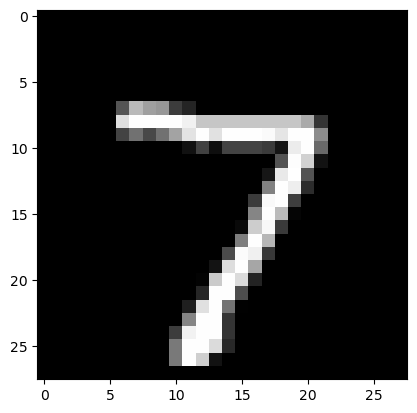

In [177]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

test_labels = test_labels[:100]
test_images = test_images[:100]#.reshape(-1, 28 * 28) / 255.0

test_images = test_images.reshape((100, 28,28,1))
predictions = np.argmax(mnist_model.predict(test_images), axis = 1)

plt.imshow(test_images[0], cmap='gray')

accuracy = np.sum(predictions == test_labels) / len(test_labels)
print('Restored model, accuracy: {:5.2f}%'.format(100 * accuracy))

### Test inference with tooth data

extract 10 numbers for testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
correctly classified 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
correctly classified 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
correctly classified 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
correctly classified 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
correctly classified 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
correctly classified 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
correctly classified 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
correctly classified 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
correctly classified 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
correctly classified 1
Accuracy: 1.0 %


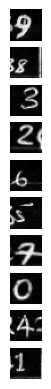

In [178]:

images = glob.glob("digits/*.png")
correct = 0
fig, ax = plt.subplots(10)
for i, filename in enumerate(images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    reshaped = cv2.resize(image, (28,28))
    label = int(filename[7])
    reshaped = 255 - reshaped # flip color
    ax[i].imshow(reshaped, cmap='gray')
    ax[i].axis('off')
    pred = np.argmax(mnist_model.predict(reshaped.reshape(1,28,28,1)), axis = 1)
    if label == pred:
        print(f'correctly classified {label}')
        correct += 1

print(f"Accuracy: {correct/10} %")

Lessons: 

- flipping color to black background improved accuracy 0.1-> 0.7
- cropping traces from adjacent characters from falsely classified images corrected all classification errors.

### Train model on new data: freeze all but last layer and use dental elements to fine tune

Skip over/underline for now, teach only upper lower script

In [179]:
# freeze layers
for layer in mnist_model.layers[:-1]:
    layer.trainable = False

for layer in mnist_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True


Next: finish labeling
one concern: labeling allows eg third canine. and third and second molar, in a way. should we just have upper/lower and then each tooth? try later. also multivariate -> just the variables next to each other or how?

In [180]:
tooth_labels = pd.read_csv('teeth/labels.csv')
tooth_labels

,m,p,c,i,u,l,1,2,3,4
0,1,0,0,0,0,1,0,0,1,0
1,0,0,0,1,1,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,1
3,1,0,0,0,0,1,0,1,0,0
4,0,1,0,0,0,1,0,1,0,0
5,0,0,0,1,1,0,1,0,0,0
6,0,0,0,1,0,1,0,0,1,0
7,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,0,1,0,0,0,0
9,0,1,0,0,0,1,0,0,1,0


In [181]:
# try training for IMPC, ignore probabilities 6-9

# convert teeth to images of shape 28x28, black and white
images = glob.glob("teeth/*.png")
tooth_images = []
for i, filename in enumerate(images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    image = image[:,:-12] #remove side pixels to get rid of number
    resized = cv2.resize(image,(28,28))
    colorflipped = 255-resized
    tooth_images.append(colorflipped)

teeth = np.array(tooth_images)
teeth = teeth.reshape(teeth.shape[0], teeth.shape[1], teeth.shape[2], 1)
teeth.shape


(30, 28, 28, 1)

In [165]:
def normalize(x):
    return x / x.sum(axis=0)
normalized_labels = np.array(tooth_labels.apply(normalize, axis=1))

# label sum to 1 so it matches with model softmax output
print(normalized_labels)

[[0.33333333 0.         0.         0.         0.         0.33333333
  0.         0.         0.33333333 0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.         0.         0.33333333 0.        ]
 [0.         0.33333333 0.         0.         0.         0.33333333
  0.         0.         0.         0.33333333]
 [0.33333333 0.         0.         0.         0.         0.33333333
  0.         0.33333333 0.         0.        ]
 [0.         0.33333333 0.         0.         0.         0.33333333
  0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.         0.33333333
  0.         0.         0.33333333 0.        ]
 [0.33333333 0.         0.         0.         0.         0.33333333
  0.33333333 0.         0.         0.        ]
 [0.         0.         0.5        0.         0.         0.5
  0.         0.         0.         

In [182]:
X_train = teeth
Y_train = normalized_labels
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
# train set: 27 samples, test set: 3 samples

(27, 28, 28, 1) (3, 28, 28, 1) (27, 10) (3, 10)


In [183]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint# early stopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model # basic class for specifying and training a neural network

In [151]:
model = mnist_model

# steps copied from mnist classifier notebook
batch_size = 128 # in each iteration, we consider 128 training examples at once
num_epochs = 50 # we iterate twelve times over the entire training set
X_train = X_train.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



In [152]:
datagen.fit(X_train)


# checkpointer = ModelCheckpoint('model-mnist.keras', verbose=1, save_best_only=True)
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,checkpointer])
model.evaluate(X_val, Y_val, verbose=1) # Evaluate the trained model on the test set!


Epoch 1/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss did not improve from 45.44588
1/1 - 2s - 2s/step - accuracy: 0.1111 - loss: 2.2070 - val_accuracy: 0.0000e+00 - val_loss: 188.0487 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss did not improve from 45.44588
1/1 - 0s - 98ms/step - accuracy: 0.0370 - loss: 2.1936 - val_accuracy: 0.0000e+00 - val_loss: 188.4683 - learning_rate: 0.0010
Epoch 3/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)



Epoch 3: val_loss did not improve from 45.44588
1/1 - 0s - 94ms/step - accuracy: 0.0370 - loss: 2.2550 - val_accuracy: 0.0000e+00 - val_loss: 188.6400 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss did not improve from 45.44588
1/1 - 0s - 93ms/step - accuracy: 0.1111 - loss: 2.2155 - val_accuracy: 0.0000e+00 - val_loss: 188.7544 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve from 45.44588
1/1 - 0s - 95ms/step - accuracy: 0.0741 - loss: 2.1937 - val_accuracy: 0.0000e+00 - val_loss: 188.8440 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: val_loss did not improve from 45.44588
1/1 - 0s - 96ms/step - accuracy: 0.0741 - loss: 2.2764 - val_accuracy: 0.0000e+00 - val_loss: 188.9937 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: val_loss did not improve from 45.44588
1/1 - 0s - 95ms/step - accuracy: 0.0741 - loss: 2.1746 - val_accuracy: 0.0000e+00 - val_loss: 189.1885 - learning_rate: 0.0010
Epoch 8/50

Epoch 8: val_loss did not improve from 45.44588
1/1 - 0s - 96ms/

[196.69085693359375, 0.0]

### Try classification M P I or C

In [168]:
type_labels = tooth_labels.iloc[:,:4]
print(type_labels)

    m  p  c  i
0   1  0  0  0
1   0  0  0  1
2   0  1  0  0
3   1  0  0  0
4   0  1  0  0
5   0  0  0  1
6   0  0  0  1
7   1  0  0  0
8   0  0  1  0
9   0  1  0  0
10  1  0  0  0
11  0  0  0  1
12  0  1  0  0
13  1  0  0  0
14  0  0  1  0
15  1  0  0  0
16  0  0  0  1
17  1  0  0  0
18  0  1  0  0
19  0  1  0  0
20  0  1  0  0
21  0  1  0  0
22  0  1  0  0
23  0  1  0  0
24  0  0  0  1
25  0  1  0  0
26  0  0  0  1
27  1  0  0  0
28  1  0  0  0
29  0  1  0  0


In [184]:
new_output = Dense(4, activation='softmax')(mnist_model.layers[-2].output)
new_model = Model(mnist_model.input, new_output)
new_model.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=conv2d_16, built=True>,
 <Conv2D name=conv2d_17, built=True>,
 <MaxPooling2D name=max_pooling2d_8, built=True>,
 <Dropout name=dropout_12, built=True>,
 <Conv2D name=conv2d_18, built=True>,
 <Conv2D name=conv2d_19, built=True>,
 <MaxPooling2D name=max_pooling2d_9, built=True>,
 <Dropout name=dropout_13, built=True>,
 <Flatten name=flatten_4, built=True>,
 <Dense name=dense_8, built=True>,
 <Dropout name=dropout_14, built=True>,
 <Dense name=dense_14, built=True>]

In [185]:
for layer in new_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True


In [186]:
X_train = teeth
Y_train = type_labels
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(27, 28, 28, 1) (3, 28, 28, 1) (27, 4) (3, 4)


In [187]:
model = new_model

# steps copied from mnist classifier notebook
batch_size = 128 # in each iteration, we consider 128 training examples at once
num_epochs = 50 # we iterate twelve times over the entire training set
X_train = X_train.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [188]:
datagen.fit(X_train)

# checkpointer = ModelCheckpoint('model-mnist.keras', verbose=1, save_best_only=True)
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,checkpointer])
model.evaluate(X_train, Y_train, verbose=1) # Evaluate on training data: too little test data

Epoch 1/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from 22.05625 to 12.72072, saving model to model-mnist.keras
1/1 - 2s - 2s/step - accuracy: 0.2222 - loss: 1.4982 - val_accuracy: 0.0000e+00 - val_loss: 12.7207 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss did not improve from 12.72072
1/1 - 0s - 104ms/step - accuracy: 0.2593 - loss: 1.5125 - val_accuracy: 0.0000e+00 - val_loss: 13.8295 - learning_rate: 0.0010
Epoch 3/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)



Epoch 3: val_loss did not improve from 12.72072
1/1 - 0s - 111ms/step - accuracy: 0.2593 - loss: 1.4239 - val_accuracy: 0.0000e+00 - val_loss: 14.9885 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss did not improve from 12.72072
1/1 - 0s - 117ms/step - accuracy: 0.1852 - loss: 1.5233 - val_accuracy: 0.0000e+00 - val_loss: 16.4320 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve from 12.72072
1/1 - 0s - 196ms/step - accuracy: 0.1852 - loss: 1.4839 - val_accuracy: 0.0000e+00 - val_loss: 18.1728 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: val_loss did not improve from 12.72072
1/1 - 0s - 250ms/step - accuracy: 0.2963 - loss: 1.3890 - val_accuracy: 0.0000e+00 - val_loss: 20.0287 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: val_loss did not improve from 12.72072
1/1 - 0s - 243ms/step - accuracy: 0.2593 - loss: 1.2969 - val_accuracy: 0.0000e+00 - val_loss: 21.9404 - learning_rate: 0.0010
Epoch 8/50

Epoch 8: val_loss did not improve from 12.72072
1/1 - 0s - 285ms

[1.1701232194900513, 0.4444444477558136]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

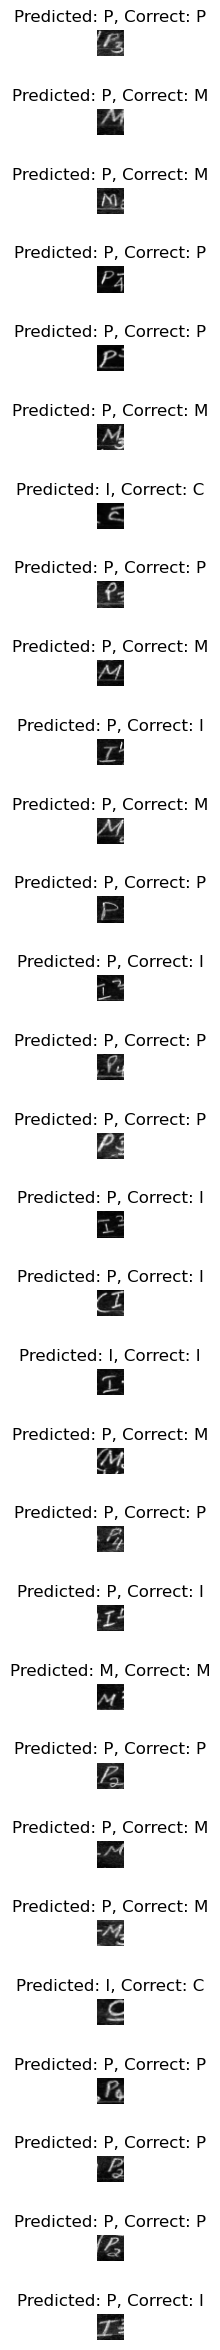

In [189]:
def id_to_tooth(id):
    if id == 0:
        return 'M'
    elif id == 1:
        return 'P'
    elif id == 2:
        return 'C'
    elif id == 3:
        return 'I'

images = glob.glob("teeth/*.png")
correct = 0
fig, ax = plt.subplots(30, figsize = (500,30))
plt.subplots_adjust(hspace=2)
for i, filename in enumerate(images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    reshaped = cv2.resize(image[:,:-12], (28,28))
    img_num = filename.split('.')[0].split('/')[1]
    loc = int(img_num)
    label = type_labels.iloc[loc]
    reshaped = 255 - reshaped # flip color
    pred = model.predict(reshaped.reshape(1,28,28,1))
    pred_tooth = id_to_tooth(np.argmax(pred))
    correct_tooth = id_to_tooth(np.argmax(label))
    fig_title = f'Predicted: {pred_tooth}, Correct: {correct_tooth}'
    if pred_tooth == correct_tooth:
        correct += 1
    
    ax[i].imshow(reshaped, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(fig_title)

print(f"Accuracy: {correct/30} %")